In [1]:
!pip install torchinfo

# Import Libraries

In [2]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
import seaborn as sns

# Configuration

In [3]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


# Variables

In [4]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_dir = "/kaggle/input/tea-leaf-disease/Tea_Leaf_Disease" #Dataset-2
output_dir = "/kaggle/working/processed-dataset"  
checkpoints_path = "/kaggle/working/"
os.makedirs(output_dir, exist_ok=True)

train_batch = 32
test_batch = 16
total_class = 6
learning_rate = 0.0001
decay = 1e-4
epoch = 100
patience = 100

# Explore Dataset

In [5]:
def load_split(split_dir):
    file_paths, labels = [], []
    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                file_paths.append(os.path.join(class_dir, image_name))
                labels.append(class_name)
    return pd.DataFrame({"file_path": file_paths, "label": labels})

data = load_split(os.path.join(data_dir, "/kaggle/input/tea-leaf-disease/Tea_Leaf_Disease"))

In [6]:
train_dataframe, temp_dataframe = train_test_split(
    data, 
    test_size=0.30, 
    stratify=data['label'], 
    random_state=42
)

validation_dataframe, test_dataframe = train_test_split(
    temp_dataframe, 
    test_size=0.50, 
    stratify=temp_dataframe['label'], 
    random_state=42
)

Dataset Split Ratios
Train: 4106 images (69.98%)
Test: 881 images (15.02%)
Validation: 880 images (15.00%)


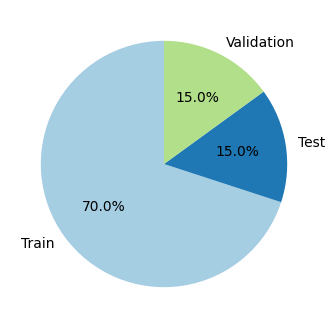

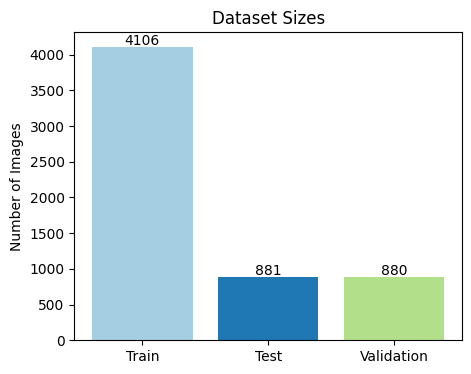

In [7]:
sizes = {
    "Train": len(train_dataframe),
    "Test": len(test_dataframe),
    "Validation": len(validation_dataframe)
}

total = sum(sizes.values())
ratios = {k: (v / total) * 100 for k, v in sizes.items()}

print("Dataset Split Ratios")
for split in sizes.keys():
    print(f"{split}: {sizes[split]} images ({ratios[split]:.2f}%)")

plt.figure(figsize=(4, 4))
plt.pie(
    sizes.values(),
    labels=sizes.keys(),
    autopct="%.1f%%",
    startangle=90,
    colors=["#a6cee3", "#1f78b4", "#b2df8a"]
)
plt.show()

plt.figure(figsize=(5, 4))
plt.bar(sizes.keys(), sizes.values(), color=["#a6cee3", "#1f78b4", "#b2df8a"])
plt.ylabel("Number of Images")
plt.title("Dataset Sizes")
y_max = max(sizes.values()) * 1.05 
plt.ylim(0, y_max)
for i, v in enumerate(sizes.values()):
    plt.text(i, v + total*0.005, str(v), ha='center')  
plt.show()

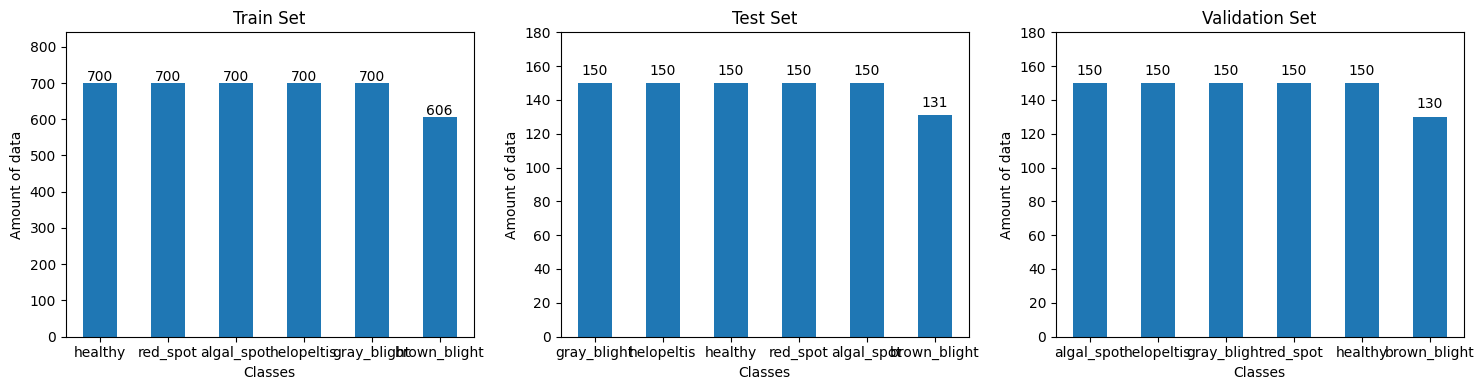

In [8]:
def class_distribution(train_df, test_df, val_df):
    datasets = {
        "Train": train_df,
        "Test": test_df,
        "Validation": val_df
    }
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for ax, (split_name, df) in zip(axes, datasets.items()):
        class_counts = df['label'].value_counts()

        class_counts.plot(kind='bar', ax=ax)
        ax.set_xlabel('Classes')
        ax.set_ylabel('Amount of data')
        ax.set_title(f'{split_name} Set')
        ax.set_xticks(range(len(class_counts)))
        ax.set_xticklabels(class_counts.index, rotation=360)
        
        for i, count in enumerate(class_counts):
            ax.text(i, count + 5, str(count), ha='center')
        ax.set_ylim(0, max(class_counts) * 1.2)
    
    plt.tight_layout()
    plt.show()

class_distribution(train_dataframe, test_dataframe, validation_dataframe)

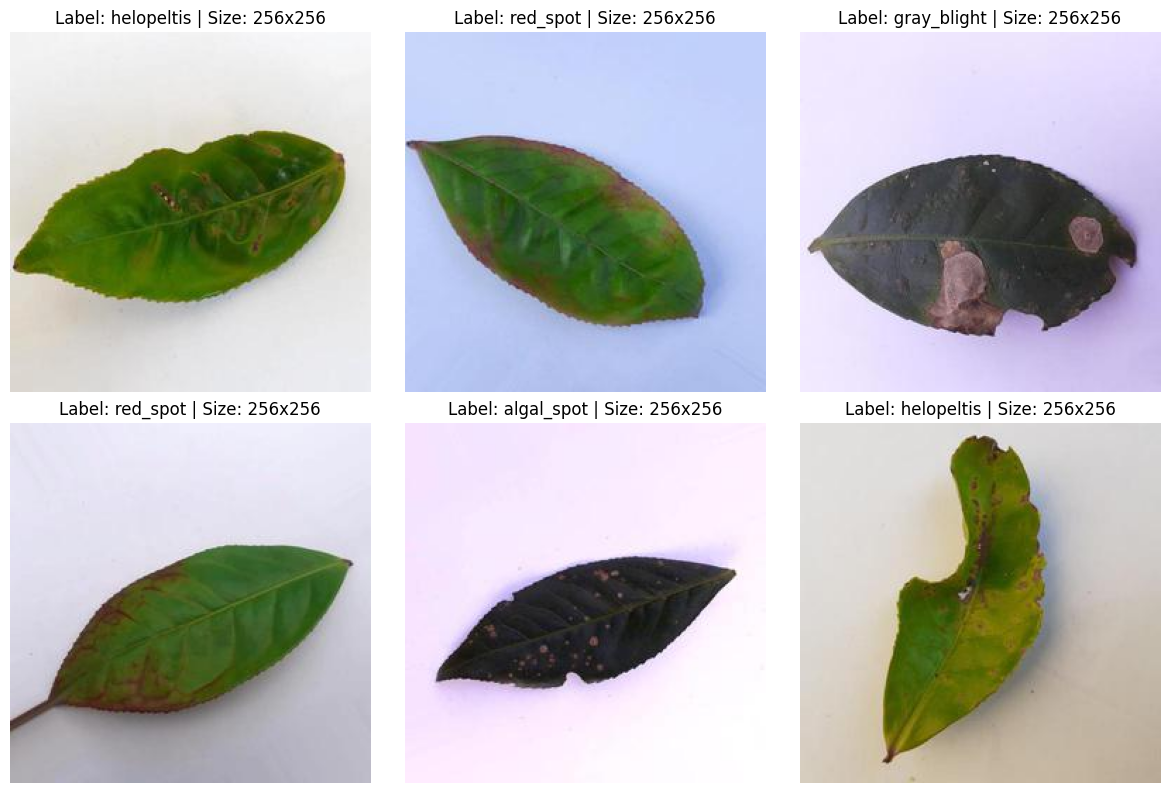

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  
axes = axes.flatten() 

for ax in axes:
    random_index = random.randint(0, len(train_dataframe) - 1)
    random_row = train_dataframe.iloc[random_index]

    file_path = random_row['file_path']
    label = random_row['label']

    image = Image.open(file_path)
    width, height = image.size

    ax.imshow(image)
    ax.set_title(f"Label: {label} | Size: {width}x{height}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Data Preprocessing 

In [10]:
sample_image_path = train_dataframe['file_path'].iloc[0]
img = Image.open(sample_image_path)
num_channels = len(img.getbands())
print(f"Number of channels: {num_channels}")

Number of channels: 3


In [11]:
def data_preprocess(df, split_name, size=(224, 224), quality=100):
    split_dir = os.path.join(output_dir, split_name)
    os.makedirs(split_dir, exist_ok=True)

    processed_file_paths = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {split_name}"):
        label = row['label']
        label_dir = os.path.join(split_dir, label)
        os.makedirs(label_dir, exist_ok=True)

        img = Image.open(row['file_path']).convert("RGB")  
        img = img.resize(size, Image.Resampling.LANCZOS)

        file_name = os.path.basename(row['file_path'])
        save_path = os.path.join(label_dir, file_name)
        img.save(save_path, optimize=True, quality=quality)

        processed_file_paths.append(save_path)

    df['file_path'] = processed_file_paths
    return df

train_dataframe = data_preprocess(train_dataframe, "train")
validation_dataframe = data_preprocess(validation_dataframe, "val")
test_dataframe = data_preprocess(test_dataframe, "test")

Processing test: 100%|██████████| 881/881 [00:03<00:00, 225.31it/s]


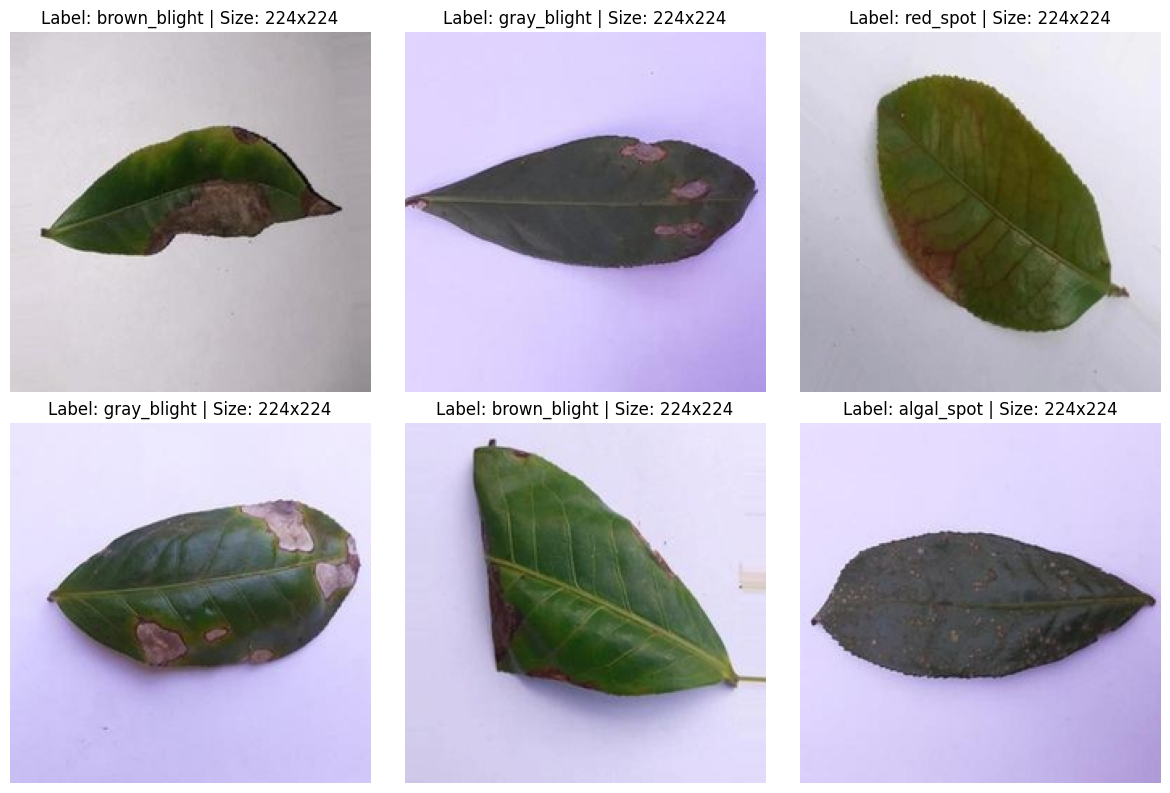

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  
axes = axes.flatten() 

for ax in axes:
    random_index = random.randint(0, len(train_dataframe) - 1)
    random_row = train_dataframe.iloc[random_index]

    file_path = random_row['file_path']
    label = random_row['label']

    image = Image.open(file_path)
    width, height = image.size

    ax.imshow(image)
    ax.set_title(f"Label: {label} | Size: {width}x{height}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Dataset Class, Data Transform and Dataloader

In [13]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        unique_labels = sorted(self.dataframe['label'].unique())
        self.label_map = {label: idx for idx, label in enumerate(unique_labels)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [14]:
def data_transfrom():

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    train_transform = transforms.Compose([
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.GaussianBlur(kernel_size=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    train_dataset = ImageDataset (
        train_dataframe,
        train_transform,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        validation_dataframe,
        transform,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_dataframe,
        transform,
        is_lb=True
    )

    print("Label encoding:")
    for label, idx in train_dataset.label_map.items():
        print(f"{label} -> {idx}")
        
    train_dataloader = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    validation_dataloader = DataLoader(valid_dataset, batch_size = test_batch, shuffle=False, num_workers=2)
    test_dataloader = DataLoader(test_dataset, batch_size = test_batch, shuffle=False, num_workers=2)

    return train_dataloader, validation_dataloader, test_dataloader

train_dataloader, validation_dataloader, test_dataloader = data_transfrom()

Label encoding:
algal_spot -> 0
brown_blight -> 1
gray_blight -> 2
healthy -> 3
helopeltis -> 4
red_spot -> 5


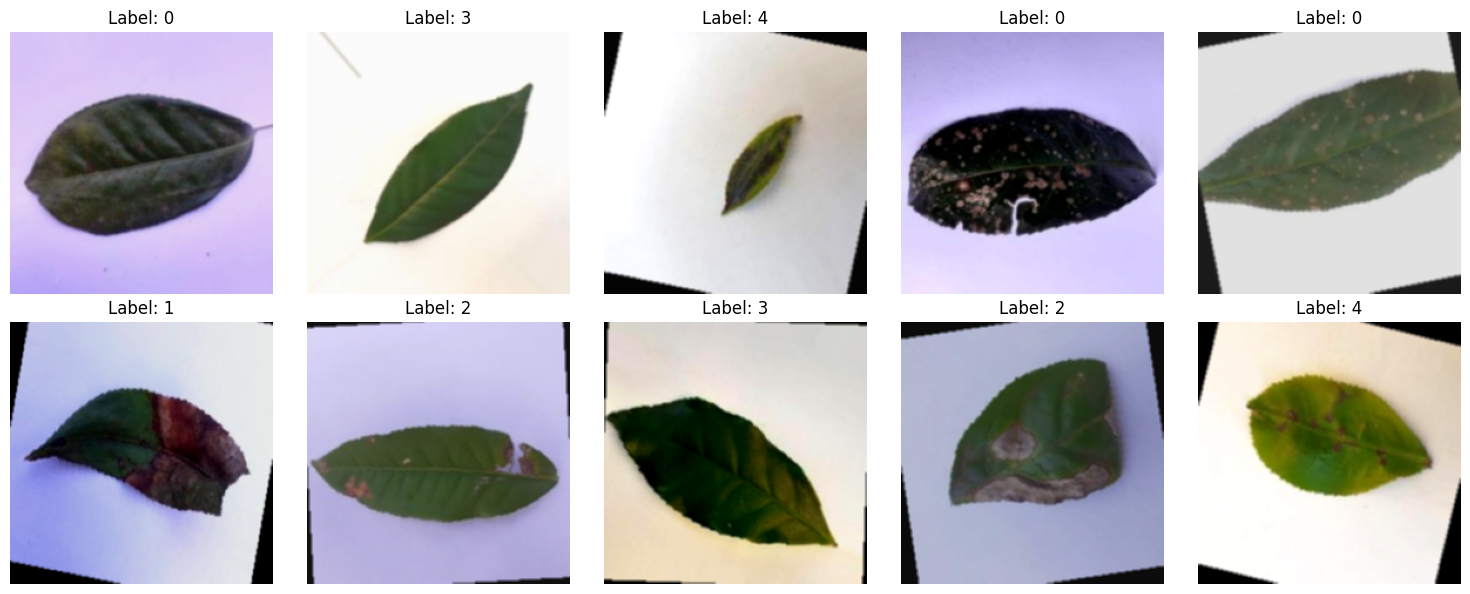

In [15]:
def augmented_samples(dataloader, num_images=10):
    images, labels = next(iter(dataloader))  

    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    images = images * std[None, :, None, None] + mean[None, :, None, None]
    images = torch.clamp(images, 0, 1)  

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        if i >= num_images:
            break
        img = images[i].permute(1, 2, 0).cpu().numpy() 
        label = labels[i].item()
        ax.imshow(img)
        ax.set_title(f"Label: {label}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

augmented_samples(train_dataloader)

# Deep Learning Model

In [16]:
class BrainCancerNet(nn.Module):
    def __init__(self, num_classes):
        super(BrainCancerNet, self).__init__()
        
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 112x112
            
            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 56x56
            
            # Conv Block 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 28x28
            
            # Conv Block 4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 14x14
            
            # Conv Block 5
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 7x7
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [17]:
num_classes = total_class  
model = BrainCancerNet(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)
criterion = nn.CrossEntropyLoss()
summary(model, input_size=(train_batch, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
BrainCancerNet                           [32, 6]                   --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 32, 224, 224]        896
│    └─BatchNorm2d: 2-2                  [32, 32, 224, 224]        64
│    └─ReLU: 2-3                         [32, 32, 224, 224]        --
│    └─MaxPool2d: 2-4                    [32, 32, 112, 112]        --
│    └─Conv2d: 2-5                       [32, 64, 112, 112]        18,496
│    └─BatchNorm2d: 2-6                  [32, 64, 112, 112]        128
│    └─ReLU: 2-7                         [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-8                    [32, 64, 56, 56]          --
│    └─Conv2d: 2-9                       [32, 128, 56, 56]         73,856
│    └─BatchNorm2d: 2-10                 [32, 128, 56, 56]         256
│    └─ReLU: 2-11                        [32, 128, 56, 56]         --
│   

# Custom CNN in Dataset-2

In [18]:
start_time = time.time()

def train_model(model, criterion, optimizer, train_dataloader, validation_dataloader, num_epochs=epoch, early_stop_patience=patience, checkpoints_path="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in validation_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{checkpoints_path}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1
            print(f"EARLY STOP COUNTER {consecutive_no_improvement} (NO IMPROVEMENT IN VALIDATION ACCURACY)")

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
            print(f"EARLY STOP COUNTER {num_epochs_loss_greater} (VALIDATION LOSS IS HIGHER)")
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, train_dataloader, validation_dataloader, checkpoints_path=checkpoints_path)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}


Epoch 1/100: 100%|██████████| 129/129 [00:17<00:00,  7.34it/s, acc=0.443, loss=1.47]

Training Loss: 1.469 Acc: 0.443


Validation Loss: 0.910 Acc: 0.634
Best model saved at epoch 1 with validation accuracy: 0.634


Epoch 2/100: 100%|██████████| 129/129 [00:17<00:00,  7.32it/s, acc=0.62, loss=0.958] 

Training Loss: 0.958 Acc: 0.620


Validation Loss: 0.692 Acc: 0.740
Best model saved at epoch 2 with validation accuracy: 0.740


Epoch 3/100: 100%|██████████| 129/129 [00:17<00:00,  7.38it/s, acc=0.694, loss=0.789]

Training Loss: 0.789 Acc: 0.694


Validation Loss: 1.265 Acc: 0.562
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 4/100: 100%|██████████| 129/129 [00:17<00:00,  7.26it/s, acc=0.734, loss=0.72] 

Training Loss: 0.720 Acc: 0.734


Validation Loss: 0.515 Acc: 0.795
Best model saved at epoch 4 with validation accuracy: 0.795


Epoch 5/100: 100%|██████████| 129/129 [00:18<00:00,  7.05it/s, acc=0.775, loss=0.61] 

Training Loss: 0.610 Acc: 0.775


Validation Loss: 0.816 Acc: 0.708
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 6/100: 100%|██████████| 129/129 [00:17<00:00,  7.22it/s, acc=0.809, loss=0.535]

Training Loss: 0.535 Acc: 0.809


Validation Loss: 0.437 Acc: 0.831
Best model saved at epoch 6 with validation accuracy: 0.831


Epoch 7/100: 100%|██████████| 129/129 [00:18<00:00,  7.16it/s, acc=0.828, loss=0.479]

Training Loss: 0.479 Acc: 0.828


Validation Loss: 0.458 Acc: 0.840
Best model saved at epoch 7 with validation accuracy: 0.840


Epoch 8/100: 100%|██████████| 129/129 [00:17<00:00,  7.18it/s, acc=0.852, loss=0.416]

Training Loss: 0.416 Acc: 0.852


Validation Loss: 0.402 Acc: 0.860
Best model saved at epoch 8 with validation accuracy: 0.860


Epoch 9/100: 100%|██████████| 129/129 [00:17<00:00,  7.24it/s, acc=0.867, loss=0.392]

Training Loss: 0.392 Acc: 0.867


Validation Loss: 0.396 Acc: 0.864
Best model saved at epoch 9 with validation accuracy: 0.864
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 10/100: 100%|██████████| 129/129 [00:17<00:00,  7.22it/s, acc=0.874, loss=0.36] 

Training Loss: 0.360 Acc: 0.874


Validation Loss: 0.262 Acc: 0.905
Best model saved at epoch 10 with validation accuracy: 0.905


Epoch 11/100: 100%|██████████| 129/129 [00:17<00:00,  7.25it/s, acc=0.883, loss=0.335]

Training Loss: 0.335 Acc: 0.883


Validation Loss: 0.277 Acc: 0.897
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 12/100: 100%|██████████| 129/129 [00:17<00:00,  7.26it/s, acc=0.889, loss=0.316]

Training Loss: 0.316 Acc: 0.889


Validation Loss: 0.272 Acc: 0.899
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 13/100: 100%|██████████| 129/129 [00:18<00:00,  7.15it/s, acc=0.885, loss=0.323]

Training Loss: 0.323 Acc: 0.885


Validation Loss: 0.384 Acc: 0.873
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 14/100: 100%|██████████| 129/129 [00:18<00:00,  7.14it/s, acc=0.903, loss=0.267]

Training Loss: 0.267 Acc: 0.903


Validation Loss: 0.219 Acc: 0.923
Best model saved at epoch 14 with validation accuracy: 0.923


Epoch 15/100: 100%|██████████| 129/129 [00:17<00:00,  7.21it/s, acc=0.908, loss=0.261]

Training Loss: 0.261 Acc: 0.908


Validation Loss: 0.285 Acc: 0.899
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 16/100: 100%|██████████| 129/129 [00:17<00:00,  7.21it/s, acc=0.905, loss=0.265]

Training Loss: 0.265 Acc: 0.905


Validation Loss: 0.206 Acc: 0.924
Best model saved at epoch 16 with validation accuracy: 0.924


Epoch 17/100: 100%|██████████| 129/129 [00:17<00:00,  7.23it/s, acc=0.914, loss=0.252]

Training Loss: 0.252 Acc: 0.914


Validation Loss: 0.179 Acc: 0.934
Best model saved at epoch 17 with validation accuracy: 0.934


Epoch 18/100: 100%|██████████| 129/129 [00:17<00:00,  7.24it/s, acc=0.919, loss=0.237]

Training Loss: 0.237 Acc: 0.919


Validation Loss: 0.263 Acc: 0.911
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 19/100: 100%|██████████| 129/129 [00:18<00:00,  7.10it/s, acc=0.922, loss=0.232]

Training Loss: 0.232 Acc: 0.922


Validation Loss: 0.197 Acc: 0.928
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 20/100: 100%|██████████| 129/129 [00:18<00:00,  7.09it/s, acc=0.913, loss=0.232]

Training Loss: 0.232 Acc: 0.913


Validation Loss: 0.192 Acc: 0.936
Best model saved at epoch 20 with validation accuracy: 0.936


Epoch 21/100: 100%|██████████| 129/129 [00:17<00:00,  7.19it/s, acc=0.92, loss=0.223] 

Training Loss: 0.223 Acc: 0.920


Validation Loss: 0.156 Acc: 0.939
Best model saved at epoch 21 with validation accuracy: 0.939


Epoch 22/100: 100%|██████████| 129/129 [00:18<00:00,  7.16it/s, acc=0.926, loss=0.211]

Training Loss: 0.211 Acc: 0.926


Validation Loss: 0.150 Acc: 0.950
Best model saved at epoch 22 with validation accuracy: 0.950


Epoch 23/100: 100%|██████████| 129/129 [00:17<00:00,  7.23it/s, acc=0.932, loss=0.193]

Training Loss: 0.193 Acc: 0.932


Validation Loss: 0.210 Acc: 0.917
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 24/100: 100%|██████████| 129/129 [00:17<00:00,  7.19it/s, acc=0.934, loss=0.181]

Training Loss: 0.181 Acc: 0.934


Validation Loss: 0.180 Acc: 0.945
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 25/100: 100%|██████████| 129/129 [00:17<00:00,  7.27it/s, acc=0.926, loss=0.199]

Training Loss: 0.199 Acc: 0.926


Validation Loss: 0.143 Acc: 0.943
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 26/100: 100%|██████████| 129/129 [00:18<00:00,  7.12it/s, acc=0.937, loss=0.18] 

Training Loss: 0.180 Acc: 0.937


Validation Loss: 0.130 Acc: 0.956
Best model saved at epoch 26 with validation accuracy: 0.956


Epoch 27/100: 100%|██████████| 129/129 [00:17<00:00,  7.24it/s, acc=0.94, loss=0.169] 

Training Loss: 0.169 Acc: 0.940


Validation Loss: 0.146 Acc: 0.951
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 28/100: 100%|██████████| 129/129 [00:18<00:00,  7.10it/s, acc=0.946, loss=0.147]

Training Loss: 0.147 Acc: 0.946


Validation Loss: 0.154 Acc: 0.939
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 29/100: 100%|██████████| 129/129 [00:18<00:00,  7.14it/s, acc=0.946, loss=0.151]

Training Loss: 0.151 Acc: 0.946


Validation Loss: 0.113 Acc: 0.955
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 30/100: 100%|██████████| 129/129 [00:17<00:00,  7.25it/s, acc=0.948, loss=0.148]

Training Loss: 0.148 Acc: 0.948


Validation Loss: 0.218 Acc: 0.923
EARLY STOP COUNTER 4 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 31/100: 100%|██████████| 129/129 [00:18<00:00,  7.07it/s, acc=0.944, loss=0.159]

Training Loss: 0.159 Acc: 0.944


Validation Loss: 0.207 Acc: 0.931
EARLY STOP COUNTER 5 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 32/100: 100%|██████████| 129/129 [00:18<00:00,  7.14it/s, acc=0.946, loss=0.158]

Training Loss: 0.158 Acc: 0.946


Validation Loss: 0.118 Acc: 0.959
Best model saved at epoch 32 with validation accuracy: 0.959


Epoch 33/100: 100%|██████████| 129/129 [00:17<00:00,  7.22it/s, acc=0.944, loss=0.159]

Training Loss: 0.159 Acc: 0.944


Validation Loss: 0.163 Acc: 0.939
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 34/100: 100%|██████████| 129/129 [00:18<00:00,  7.08it/s, acc=0.952, loss=0.139]

Training Loss: 0.139 Acc: 0.952


Validation Loss: 0.331 Acc: 0.897
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 35/100: 100%|██████████| 129/129 [00:17<00:00,  7.22it/s, acc=0.946, loss=0.159]

Training Loss: 0.159 Acc: 0.946


Validation Loss: 0.297 Acc: 0.890
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 3 (VALIDATION LOSS IS HIGHER)


Epoch 36/100: 100%|██████████| 129/129 [00:17<00:00,  7.17it/s, acc=0.946, loss=0.147]

Training Loss: 0.147 Acc: 0.946


Validation Loss: 0.100 Acc: 0.965
Best model saved at epoch 36 with validation accuracy: 0.965


Epoch 37/100: 100%|██████████| 129/129 [00:17<00:00,  7.31it/s, acc=0.952, loss=0.129]

Training Loss: 0.129 Acc: 0.952


Validation Loss: 0.179 Acc: 0.928
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 38/100: 100%|██████████| 129/129 [00:17<00:00,  7.22it/s, acc=0.96, loss=0.121] 

Training Loss: 0.121 Acc: 0.960


Validation Loss: 0.117 Acc: 0.953
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 39/100: 100%|██████████| 129/129 [00:17<00:00,  7.29it/s, acc=0.947, loss=0.15] 

Training Loss: 0.150 Acc: 0.947


Validation Loss: 0.132 Acc: 0.949
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 40/100: 100%|██████████| 129/129 [00:17<00:00,  7.22it/s, acc=0.954, loss=0.132]

Training Loss: 0.132 Acc: 0.954


Validation Loss: 0.091 Acc: 0.964
EARLY STOP COUNTER 4 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 41/100: 100%|██████████| 129/129 [00:17<00:00,  7.26it/s, acc=0.955, loss=0.136]

Training Loss: 0.136 Acc: 0.955


Validation Loss: 0.139 Acc: 0.947
EARLY STOP COUNTER 5 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 42/100: 100%|██████████| 129/129 [00:17<00:00,  7.33it/s, acc=0.955, loss=0.126]

Training Loss: 0.126 Acc: 0.955


Validation Loss: 0.105 Acc: 0.966
Best model saved at epoch 42 with validation accuracy: 0.966


Epoch 43/100: 100%|██████████| 129/129 [00:17<00:00,  7.28it/s, acc=0.958, loss=0.114]

Training Loss: 0.114 Acc: 0.958


Validation Loss: 0.148 Acc: 0.947
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 44/100: 100%|██████████| 129/129 [00:17<00:00,  7.34it/s, acc=0.956, loss=0.119]

Training Loss: 0.119 Acc: 0.956


Validation Loss: 0.120 Acc: 0.958
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 45/100: 100%|██████████| 129/129 [00:17<00:00,  7.31it/s, acc=0.954, loss=0.113]

Training Loss: 0.113 Acc: 0.954


Validation Loss: 0.145 Acc: 0.955
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 3 (VALIDATION LOSS IS HIGHER)


Epoch 46/100: 100%|██████████| 129/129 [00:17<00:00,  7.26it/s, acc=0.956, loss=0.128]

Training Loss: 0.128 Acc: 0.956


Validation Loss: 0.097 Acc: 0.957
EARLY STOP COUNTER 4 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 47/100: 100%|██████████| 129/129 [00:17<00:00,  7.20it/s, acc=0.96, loss=0.115] 

Training Loss: 0.115 Acc: 0.960


Validation Loss: 0.094 Acc: 0.965
EARLY STOP COUNTER 5 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 48/100: 100%|██████████| 129/129 [00:17<00:00,  7.33it/s, acc=0.963, loss=0.11] 

Training Loss: 0.110 Acc: 0.963


Validation Loss: 0.117 Acc: 0.957
EARLY STOP COUNTER 6 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 49/100: 100%|██████████| 129/129 [00:17<00:00,  7.31it/s, acc=0.955, loss=0.118]

Training Loss: 0.118 Acc: 0.955


Validation Loss: 0.104 Acc: 0.958
EARLY STOP COUNTER 7 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 50/100: 100%|██████████| 129/129 [00:17<00:00,  7.21it/s, acc=0.962, loss=0.108]

Training Loss: 0.108 Acc: 0.962


Validation Loss: 0.170 Acc: 0.928
EARLY STOP COUNTER 8 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 51/100: 100%|██████████| 129/129 [00:18<00:00,  7.13it/s, acc=0.965, loss=0.0996]

Training Loss: 0.100 Acc: 0.965


Validation Loss: 0.142 Acc: 0.948
EARLY STOP COUNTER 9 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 52/100: 100%|██████████| 129/129 [00:17<00:00,  7.20it/s, acc=0.96, loss=0.104] 

Training Loss: 0.104 Acc: 0.960


Validation Loss: 0.109 Acc: 0.961
EARLY STOP COUNTER 10 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 3 (VALIDATION LOSS IS HIGHER)


Epoch 53/100: 100%|██████████| 129/129 [00:18<00:00,  7.14it/s, acc=0.963, loss=0.105]

Training Loss: 0.105 Acc: 0.963


Validation Loss: 0.110 Acc: 0.963
EARLY STOP COUNTER 11 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 4 (VALIDATION LOSS IS HIGHER)


Epoch 54/100: 100%|██████████| 129/129 [00:17<00:00,  7.27it/s, acc=0.96, loss=0.111] 

Training Loss: 0.111 Acc: 0.960


Validation Loss: 0.203 Acc: 0.939
EARLY STOP COUNTER 12 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 5 (VALIDATION LOSS IS HIGHER)


Epoch 55/100: 100%|██████████| 129/129 [00:17<00:00,  7.24it/s, acc=0.964, loss=0.101]

Training Loss: 0.101 Acc: 0.964


Validation Loss: 0.278 Acc: 0.917
EARLY STOP COUNTER 13 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 6 (VALIDATION LOSS IS HIGHER)


Epoch 56/100: 100%|██████████| 129/129 [00:17<00:00,  7.20it/s, acc=0.968, loss=0.0952]

Training Loss: 0.095 Acc: 0.968


Validation Loss: 0.096 Acc: 0.964
EARLY STOP COUNTER 14 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 7 (VALIDATION LOSS IS HIGHER)


Epoch 57/100: 100%|██████████| 129/129 [00:17<00:00,  7.27it/s, acc=0.965, loss=0.0939]

Training Loss: 0.094 Acc: 0.965


Validation Loss: 0.078 Acc: 0.969
Best model saved at epoch 57 with validation accuracy: 0.969


Epoch 58/100: 100%|██████████| 129/129 [00:17<00:00,  7.28it/s, acc=0.964, loss=0.101] 

Training Loss: 0.101 Acc: 0.964


Validation Loss: 0.098 Acc: 0.961
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 59/100: 100%|██████████| 129/129 [00:17<00:00,  7.31it/s, acc=0.96, loss=0.105] 

Training Loss: 0.105 Acc: 0.960


Validation Loss: 0.104 Acc: 0.961
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 60/100: 100%|██████████| 129/129 [00:17<00:00,  7.18it/s, acc=0.964, loss=0.105] 

Training Loss: 0.105 Acc: 0.964


Validation Loss: 0.281 Acc: 0.912
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 61/100: 100%|██████████| 129/129 [00:17<00:00,  7.31it/s, acc=0.963, loss=0.104]

Training Loss: 0.104 Acc: 0.963


Validation Loss: 0.076 Acc: 0.975
Best model saved at epoch 61 with validation accuracy: 0.975


Epoch 62/100: 100%|██████████| 129/129 [00:18<00:00,  7.10it/s, acc=0.971, loss=0.0861]

Training Loss: 0.086 Acc: 0.971


Validation Loss: 0.089 Acc: 0.964
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 63/100: 100%|██████████| 129/129 [00:17<00:00,  7.38it/s, acc=0.967, loss=0.0861]

Training Loss: 0.086 Acc: 0.967


Validation Loss: 0.107 Acc: 0.965
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 64/100: 100%|██████████| 129/129 [00:17<00:00,  7.20it/s, acc=0.969, loss=0.0881]

Training Loss: 0.088 Acc: 0.969


Validation Loss: 0.089 Acc: 0.975
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 3 (VALIDATION LOSS IS HIGHER)


Epoch 65/100: 100%|██████████| 129/129 [00:17<00:00,  7.27it/s, acc=0.963, loss=0.105]

Training Loss: 0.105 Acc: 0.963


Validation Loss: 0.114 Acc: 0.956
EARLY STOP COUNTER 4 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 4 (VALIDATION LOSS IS HIGHER)


Epoch 66/100: 100%|██████████| 129/129 [00:17<00:00,  7.25it/s, acc=0.969, loss=0.0856]

Training Loss: 0.086 Acc: 0.969


Validation Loss: 0.214 Acc: 0.940
EARLY STOP COUNTER 5 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 5 (VALIDATION LOSS IS HIGHER)


Epoch 67/100: 100%|██████████| 129/129 [00:17<00:00,  7.26it/s, acc=0.97, loss=0.091]  

Training Loss: 0.091 Acc: 0.970


Validation Loss: 0.148 Acc: 0.950
EARLY STOP COUNTER 6 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 6 (VALIDATION LOSS IS HIGHER)


Epoch 68/100: 100%|██████████| 129/129 [00:17<00:00,  7.39it/s, acc=0.971, loss=0.0783]

Training Loss: 0.078 Acc: 0.971


Validation Loss: 0.087 Acc: 0.970
EARLY STOP COUNTER 7 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 7 (VALIDATION LOSS IS HIGHER)


Epoch 69/100: 100%|██████████| 129/129 [00:17<00:00,  7.30it/s, acc=0.962, loss=0.0975]

Training Loss: 0.098 Acc: 0.962


Validation Loss: 0.089 Acc: 0.970
EARLY STOP COUNTER 8 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 70/100: 100%|██████████| 129/129 [00:17<00:00,  7.20it/s, acc=0.97, loss=0.0836] 

Training Loss: 0.084 Acc: 0.970


Validation Loss: 0.107 Acc: 0.961
EARLY STOP COUNTER 9 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 71/100: 100%|██████████| 129/129 [00:17<00:00,  7.44it/s, acc=0.973, loss=0.0765]

Training Loss: 0.076 Acc: 0.973


Validation Loss: 0.063 Acc: 0.974
EARLY STOP COUNTER 10 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 72/100: 100%|██████████| 129/129 [00:17<00:00,  7.23it/s, acc=0.973, loss=0.0767]

Training Loss: 0.077 Acc: 0.973


Validation Loss: 0.112 Acc: 0.960
EARLY STOP COUNTER 11 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 73/100: 100%|██████████| 129/129 [00:17<00:00,  7.26it/s, acc=0.97, loss=0.08]   

Training Loss: 0.080 Acc: 0.970


Validation Loss: 0.249 Acc: 0.938
EARLY STOP COUNTER 12 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 74/100: 100%|██████████| 129/129 [00:18<00:00,  7.15it/s, acc=0.966, loss=0.0946]

Training Loss: 0.095 Acc: 0.966


Validation Loss: 0.063 Acc: 0.976
Best model saved at epoch 74 with validation accuracy: 0.976


Epoch 75/100: 100%|██████████| 129/129 [00:18<00:00,  7.11it/s, acc=0.97, loss=0.0786] 

Training Loss: 0.079 Acc: 0.970


Validation Loss: 0.079 Acc: 0.976
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 76/100: 100%|██████████| 129/129 [00:17<00:00,  7.19it/s, acc=0.974, loss=0.0691]

Training Loss: 0.069 Acc: 0.974


Validation Loss: 0.059 Acc: 0.981
Best model saved at epoch 76 with validation accuracy: 0.981


Epoch 77/100: 100%|██████████| 129/129 [00:17<00:00,  7.25it/s, acc=0.969, loss=0.0815]

Training Loss: 0.082 Acc: 0.969


Validation Loss: 0.071 Acc: 0.981
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 78/100: 100%|██████████| 129/129 [00:17<00:00,  7.28it/s, acc=0.978, loss=0.0695]

Training Loss: 0.069 Acc: 0.978


Validation Loss: 0.060 Acc: 0.975
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 79/100: 100%|██████████| 129/129 [00:17<00:00,  7.32it/s, acc=0.967, loss=0.0933]

Training Loss: 0.093 Acc: 0.967


Validation Loss: 0.059 Acc: 0.977
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 80/100: 100%|██████████| 129/129 [00:17<00:00,  7.22it/s, acc=0.971, loss=0.0828]

Training Loss: 0.083 Acc: 0.971


Validation Loss: 0.087 Acc: 0.968
EARLY STOP COUNTER 4 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 81/100: 100%|██████████| 129/129 [00:17<00:00,  7.24it/s, acc=0.971, loss=0.081] 

Training Loss: 0.081 Acc: 0.971


Validation Loss: 0.076 Acc: 0.974
EARLY STOP COUNTER 5 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 82/100: 100%|██████████| 129/129 [00:17<00:00,  7.28it/s, acc=0.972, loss=0.0729]

Training Loss: 0.073 Acc: 0.972


Validation Loss: 0.062 Acc: 0.973
EARLY STOP COUNTER 6 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 83/100: 100%|██████████| 129/129 [00:17<00:00,  7.39it/s, acc=0.976, loss=0.0717]

Training Loss: 0.072 Acc: 0.976


Validation Loss: 0.074 Acc: 0.972
EARLY STOP COUNTER 7 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 84/100: 100%|██████████| 129/129 [00:17<00:00,  7.37it/s, acc=0.974, loss=0.0738]

Training Loss: 0.074 Acc: 0.974


Validation Loss: 0.080 Acc: 0.974
EARLY STOP COUNTER 8 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 85/100: 100%|██████████| 129/129 [00:17<00:00,  7.28it/s, acc=0.975, loss=0.0698]

Training Loss: 0.070 Acc: 0.975


Validation Loss: 0.104 Acc: 0.972
EARLY STOP COUNTER 9 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 3 (VALIDATION LOSS IS HIGHER)


Epoch 86/100: 100%|██████████| 129/129 [00:17<00:00,  7.24it/s, acc=0.974, loss=0.0722]

Training Loss: 0.072 Acc: 0.974


Validation Loss: 0.062 Acc: 0.977
EARLY STOP COUNTER 10 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 87/100: 100%|██████████| 129/129 [00:17<00:00,  7.35it/s, acc=0.98, loss=0.0599] 

Training Loss: 0.060 Acc: 0.980


Validation Loss: 0.087 Acc: 0.977
EARLY STOP COUNTER 11 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 88/100: 100%|██████████| 129/129 [00:17<00:00,  7.41it/s, acc=0.971, loss=0.0867]

Training Loss: 0.087 Acc: 0.971


Validation Loss: 0.107 Acc: 0.967
EARLY STOP COUNTER 12 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 89/100: 100%|██████████| 129/129 [00:17<00:00,  7.18it/s, acc=0.97, loss=0.084]  

Training Loss: 0.084 Acc: 0.970


Validation Loss: 0.055 Acc: 0.984
Best model saved at epoch 89 with validation accuracy: 0.984


Epoch 90/100: 100%|██████████| 129/129 [00:17<00:00,  7.24it/s, acc=0.976, loss=0.0693]

Training Loss: 0.069 Acc: 0.976


Validation Loss: 0.078 Acc: 0.967
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 91/100: 100%|██████████| 129/129 [00:17<00:00,  7.40it/s, acc=0.977, loss=0.0713]

Training Loss: 0.071 Acc: 0.977


Validation Loss: 0.147 Acc: 0.952
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 92/100: 100%|██████████| 129/129 [00:17<00:00,  7.30it/s, acc=0.978, loss=0.0635]

Training Loss: 0.064 Acc: 0.978


Validation Loss: 0.347 Acc: 0.923
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 3 (VALIDATION LOSS IS HIGHER)


Epoch 93/100: 100%|██████████| 129/129 [00:17<00:00,  7.29it/s, acc=0.975, loss=0.0716]

Training Loss: 0.072 Acc: 0.975


Validation Loss: 0.079 Acc: 0.977
EARLY STOP COUNTER 4 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 4 (VALIDATION LOSS IS HIGHER)


Epoch 94/100: 100%|██████████| 129/129 [00:17<00:00,  7.38it/s, acc=0.979, loss=0.0635]

Training Loss: 0.064 Acc: 0.979


Validation Loss: 0.073 Acc: 0.975
EARLY STOP COUNTER 5 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 5 (VALIDATION LOSS IS HIGHER)


Epoch 95/100: 100%|██████████| 129/129 [00:17<00:00,  7.28it/s, acc=0.979, loss=0.0554]

Training Loss: 0.055 Acc: 0.979


Validation Loss: 0.077 Acc: 0.976
EARLY STOP COUNTER 6 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 6 (VALIDATION LOSS IS HIGHER)


Epoch 96/100: 100%|██████████| 129/129 [00:17<00:00,  7.39it/s, acc=0.977, loss=0.0644]


Training Loss: 0.064 Acc: 0.977
Validation Loss: 0.063 Acc: 0.981
EARLY STOP COUNTER 7 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 97/100: 100%|██████████| 129/129 [00:17<00:00,  7.37it/s, acc=0.977, loss=0.066] 

Training Loss: 0.066 Acc: 0.977


Validation Loss: 0.092 Acc: 0.968
EARLY STOP COUNTER 8 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 98/100: 100%|██████████| 129/129 [00:17<00:00,  7.20it/s, acc=0.978, loss=0.0659]

Training Loss: 0.066 Acc: 0.978


Validation Loss: 0.076 Acc: 0.978
EARLY STOP COUNTER 9 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 99/100: 100%|██████████| 129/129 [00:17<00:00,  7.31it/s, acc=0.975, loss=0.0702]

Training Loss: 0.070 Acc: 0.975


Validation Loss: 0.058 Acc: 0.977
EARLY STOP COUNTER 10 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 100/100: 100%|██████████| 129/129 [00:17<00:00,  7.18it/s, acc=0.979, loss=0.0626]

Training Loss: 0.063 Acc: 0.979


Validation Loss: 0.062 Acc: 0.978
EARLY STOP COUNTER 11 (NO IMPROVEMENT IN VALIDATION ACCURACY)
Training Time: 1923.20 seconds ---> 32.05 minutes


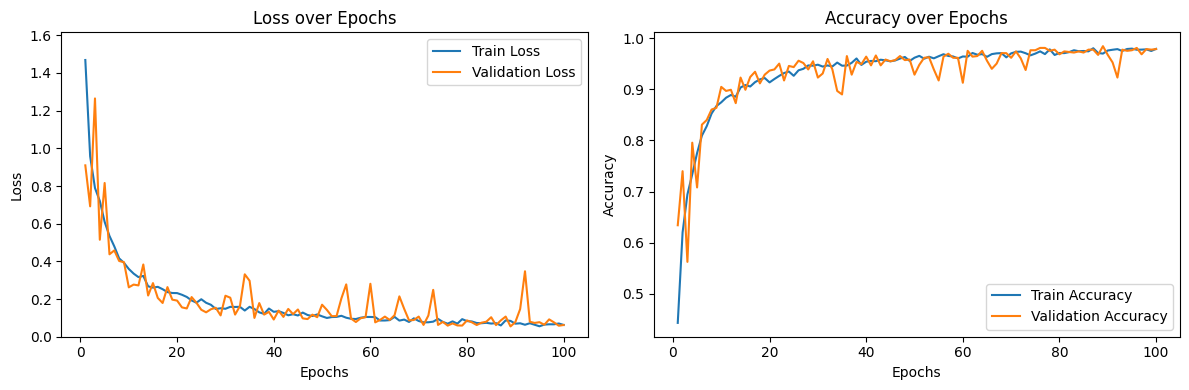

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend(loc='upper right')
plt.ylim(0, max(max(train_loss_history), max(val_loss_history)) * 1.1)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Load Saved Checkpoints

In [20]:
best_checkpoint_path = f"{checkpoints_path}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

# Evaluation

In [21]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [22]:
start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, test_dataloader)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.981
Test Time: 1.21 seconds ---> 0.02 minutes


In [23]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, test_dataloader, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       150
           1       0.98      0.96      0.97       131
           2       0.96      0.99      0.97       150
           3       0.96      1.00      0.98       150
           4       1.00      0.97      0.99       150
           5       1.00      0.97      0.98       150

    accuracy                           0.98       881
   macro avg       0.98      0.98      0.98       881
weighted avg       0.98      0.98      0.98       881

Class 0 Accuracy: 0.993
Class 1 Accuracy: 0.962
Class 2 Accuracy: 0.987
Class 3 Accuracy: 1.000
Class 4 Accuracy: 0.973
Class 5 Accuracy: 0.967


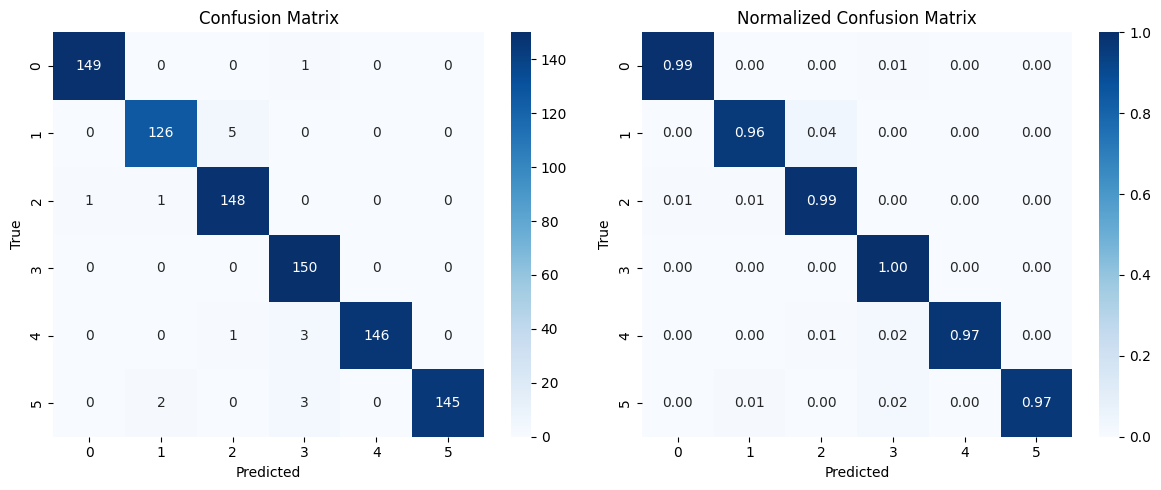

In [24]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')

plt.tight_layout()
plt.show()